<a href="https://colab.research.google.com/github/AmirhosseinFarjadi/Find-S/blob/master/Copy_of_FrozenLake_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ME5406 Part 1 Project Code**
Welcome to my Frozen Lake code! I am **Arijit Dasgupta**, A0182766R. And this is my code submission for ME5406 Part 1 Project. The first cell contains the source code for the FrozenLake class. It includes the functionality for everything to do with the FrozenLake environment, agent and RL training. The source code contains all the additional features and initiatives I added to this project. As the code is very long, I ensured that every method, algorithm and operation is supported by comments. The comments are intentionally made to be very detailed and frequent. The following cells show how a user can very easily implement all the different training algorithms and get the training results.

In the source code in the subsequent cell, the class consists 21 different methods. To make it easier to understand the code, I have categorised the 21 methods into the following 5 categories in order:-

1.   Initialising Operations: **Methods 1 - 6**
2.   Training Helper Functions: **Methods 7 - 10**
3.   Training Operations: **Methods 11 - 16**
4.   UI Printing Functions: **Methods 17 & 18**
5.   Post-processing Operations: **Methods 19 - 21** 

All libraries imported are standard (matplotlib, numpy, random, copy & time)







In [ ]:
"""
Title: The Frozen Lake Problem and Variations
Author: Arijit Dasgupta, arijit.dasgupta@u.nus.edu
Module: ME5406

This script contains the code for the python implementation of the frozen lake path planning problem via model-free Reinforcement Learning
This is written in submission as the project for part 1 of ME5406: Deep Learning for Robotics. The environment is programmed directly
into standard python data structures instead of using python packages like OpenAI's gym. 
This was entirely coded my me (I spent many productive long hours on this).
"""

# Standard Imports
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

# Setting random seed to 42 to ensure repeatable results and custom gridlakes
random.seed(42)

class FrozenLake:

	""" This class contains the entire representation of the frozen lake environment. This ranges including
	its' states, actions and rewards representations, gridlake map representation, the entire RL training operation
	as well as helper methods and visualisation methods. Basically, this class is able to handle all features of the
	FrozenLake ME5406 Part 1 Project """

	def __init__(self, gridlake_type = 'hardcoded'):

		""" Constructer initialisation, where all code is run upon initialising this class into an object"""

		# The gridlake_type can either be "hardcoded" (4 by 4) or "custom" (user specified N by M)
		# For the ME5406 Project, the "custom" option is used to represent the 10 by 10 grid in Task 2
		self.gridlake_type = gridlake_type

		# For Task 1, create the small 4x4 hardcoded gridlake (refer to create_hardcoded_gridlake() method)
		if self.gridlake_type == 'hardcoded':
			self.create_hardcoded_gridlake()


		# A dictionary is created to map the action to the [i,j] change needed to be made to robot state coordinate
		# This is consistent for both "hardcoded" and "custom". Note that a positive i is one step down and positive j is one step right
		self.action_coordinate_mapping = {
			'up': [-1, 0],
			'right': [0, 1],
			'down': [1,0],
			'left': [0,-1]
		}

		# Lists of actions and states
		states = list(self.state_coordinate_mapping.keys())
		actions = list(self.action_coordinate_mapping.keys()) 

		# Create list of terminal states and non terminal states into attributes
		# This is not hardcoded so that it can be used with any gridlake with the the assumption that any grid that is not '.' and 'R' is terminal

		# List comprehension loops through each state and checks if it is 'R' or '.', otherwise it is terminal
		self.terminal_states = [x for x in states if (self.gridlake[self.state_coordinate_mapping[x][0]][self.state_coordinate_mapping[x][1]] != '.' \
			and self.gridlake[self.state_coordinate_mapping[x][0]][self.state_coordinate_mapping[x][1]] != 'R')]

		# Negation of terminal states are non-terminal states
		self.non_terminal_states = [x for x in states if x not in self.terminal_states]


		# Initialise Q-table (lookup table) with size [number of states, number of actions] to all Zeros
		# The actions are in order of up, right, down, left
		self.q_table = np.zeros(shape = [len(self.state_coordinate_mapping), len(self.action_coordinate_mapping)])

		# Finally, initialise state_action pair list needed for montecarlo algorithms

		# Create a list to hold the name of the pairs, this list will act as a reference on the index of any state-action pair
		self.state_action_pair_list = []

		# Create another list which will hold the g_values of each pair, which corresponds to the same order as self.state_action_pair_list
		self.state_action_pair_g_value = []

		for state in self.non_terminal_states: # only consider non-terminal states for g_value pairs
			for action in actions:
				# Append a tuple of (state, action) names to the reference list 
				self.state_action_pair_list.append((state,action))

				# Append an empty list for each state-action pair. The g values will be appended to this list
				self.state_action_pair_g_value.append([])

	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
	# THE FIRST 6 METHODS (Methods 1 to 6) are responsible for all initialising operations. This includes setting #
	# the states, rewards, and gridlakes for the "Hardcoded" and "Custom" options, including resetting options.  #
	# It also has a depth first search recursive function to ensure a valid path from the robot to the frisbee.  #
	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

	### METHOD 1 ###
	def create_hardcoded_gridlake(self):

		""" Creates the 4 by 4 hardcoded grid as specified in the ME5406 Project Requirements """

		# Starting frozen lake gridlake representation, 'R' refers to the robot
		# '.' refers to empty spaces 'x' refers to hole and 'o' for the frisbee

		self.gridlake = [['R', '.', '.', '.', '.'], # states 0, 1, 2, 3, 4
                     ['.', '.', 'x', '.', '.'], # states 5, 6, 7, 8, 9
                     ['.', 'x', '.', '.', '.'], # states 10, 11, 12, 13, 14
                     ['.', '.', 'o', 'x', 'x'], # states 15, 16, 17, 18, 19
                     ['.', '.', '.', '.', '.']] # states 20, 21, 22, 23, 24

		# initialise robot state to state 0
		self.robot_state = '0'

		# Reset variables saved here to be used when resetting the gridlake
		self.reset_gridlake = copy.deepcopy(self.gridlake)
		self.reset_robot_state = self.robot_state

		# Dictionary mapping the state number to [i,j] coordinate on the gridlake
		self.state_coordinate_mapping = {
		  '0': [0,0],
      '1': [0,1],
      '2': [0,2],
      '3': [0,3],
      '4': [0,4],
      '5': [1,0],
      '6': [1,1],
      '7': [1,2],
      '8': [1,3],
      '9': [1,4],
      '10': [2,0],
      '11': [2,1],
      '12': [2,2],
      '13': [2,3],
      '14': [2,4],
      '15': [3,0],
      '16': [3,1],
      '17': [3,2],
      '18': [3,3],
      '19': [3,4],
      '20': [4,0],
      '21': [4,1],
      '22': [4,2],
      '23': [4,3],
      '24': [4,4]
		}

		# Dictionary mapping the state number to rewards. -1 for holes, 1 for frisbee and 0 otherwise 
		self.state_reward_mapping = {
			'0': -1,
			'1': -1,
			'2': -1,
			'3': -1,
			'4': -1,
			'5': -1,
			'6': -1,
			'7': -200,
			'8': -1,
			'9': -1,
			'10': -1,
			'11': -200,
			'12': -1,
			'13': -1,
			'14': -1,
			'15': -1,
			'16' : -1,
			'17' : 200,
			'18' : -200,
			'19' : -200,
			'20' : -1,
			'21' : -1,
			'22' : -1,
			'23' : -1,
			'24' : -1
		}

		# hardcoded N x M dimensions and chosen_holes
		self.N = 5
		self.M = 5
		self.chosen_holes = ["7","11","18","19"] # chosen holes refer to the states with holes

	### METHOD 3 ###
	def reset_lake(self):

		""" Resets the gridlake and robot state to the starting state """

		# Reset gridlake to starting configuration using reset variables created in METHODS 1 or 2
		# deepcopy may be slow, but is better for copying a 2D python list
		self.gridlake = copy.deepcopy(self.reset_gridlake)

		# reset robot state to original state
		self.robot_state = self.reset_robot_state

	### METHOD 4 ###
	def reset_lake_ES(self):

		""" Sets the lake with a random starting robot position (for Exploring Starts)
		This entire method extends beyond the project requirements as an initiative to 
		provide support for ES algorithms in monte carlo"""

		# set normal gridlake without robot first
		# First deepcopy the gridlake to the initial gridlake before running episode
		self.gridlake = copy.deepcopy(self.reset_gridlake)

		# Initialise chosen_holes variable (only needed for depth first search algorithm)
		self.chosen_holes = []

		# Loop through [i,j] coordinates of the gridlake
		for i in range(len(self.gridlake)):
			for j in range(len(self.gridlake[0])):

				# Remove the robot first
				if self.gridlake[i][j] == 'R':
					self.gridlake[i][j] = '.' 

				# Determine if frisbee state, then save into frisbee_state
				elif self.gridlake[i][j] == 'o':
					self.frisbee_state = self.get_robot_state_from_coordinate([i,j])

				# Determine if hole state, then save into chosen_holes variable
				elif self.gridlake[i][j] == 'x':
					self.chosen_holes.append(self.get_robot_state_from_coordinate([i,j]))

		# bool variable to determine if the robot location is valid in a while loop
		valid_holes = False

		# determine robot location randomly and ensure they are all valid
		while valid_holes == False:

			# choose a random non-terminal state as the robot starting state
			self.robot_state = random.choice(self.non_terminal_states)

			# create a 2D visit_history variable that will store the visit history of the depth first search algorithm for pruning
			# '.' indicates state is not visited and 'X' means it has been visited
			self.visit_history = [['.' for x in range(self.M)] for y in range(self.N)]

			# use a depth first search resursive function to check if there is an unblocked path from the robot to the frisbee
			valid_holes = self.valid_path_depth_first_search(state = self.robot_state)	

		# update gridlake with robot state accordingly
		self.gridlake[self.state_coordinate_mapping[self.robot_state][0]][self.state_coordinate_mapping[self.robot_state][1]] = 'R'

	### METHOD 5 ###
	def reset_training(self):

		""" resets the entire training process (without having to create a new FrozenLake object)
		This is useful when running multiple different trainings of the same gridlake in series,
		saving memory and time as a new object does not have to be created """

		# Reset lake to original
		self.reset_lake()


		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# Note that all the remaining operations in this method are exactly the same as the end of the __init__ constructor #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


		# Initialise Q-table (lookup table) with size [number of states, number of actions] to all Zeros
		# The actions are in order of up, right, down, left
		self.q_table = np.zeros(shape = [len(self.state_coordinate_mapping), len(self.action_coordinate_mapping)])

		# Finally, initialise state_action pair list needed for montecarlo algorithms

		# Create a list to hold the name of the pairs, this list will act as a reference on the index of any state-action pair
		self.state_action_pair_list = []

		# Create another list which will hold the g_values of each pair, which corresponds to the same order as self.state_action_pair_list
		self.state_action_pair_g_value = []

		# create list of actions
		actions = list(self.action_coordinate_mapping.keys())

		for state in self.non_terminal_states: # only consider non-terminal states for g_value pairs
			for action in actions:
				# Append a tuple of (state, action) names to the reference list 
				self.state_action_pair_list.append((state,action))

				# Append an empty list for each state-action pair. The g values will be appended to this list
				self.state_action_pair_g_value.append([])

	### METHOD 6 ###
	def valid_path_depth_first_search(self, state):

		""" A resursive depth first search algorithm to check if path from robot to frisbee is unblocked (True) or blocked (False).
		If any leaf node returns True, then a valid path is present. This is not part of the project requirements as it is an
		initiative to aid the process of randomly generating holes validly, or robot state for exploring starts in montecarlo """

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# Note that the self.visit_history variable is globally used in this search tree to save information on whether the     #
		# state has been searched before. This helps to significantly prune the search tree and increase search efficiency.      #
		# A '.' indicates it has NOT been visited while a 'X' indicates it has been visited.
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

		# Indicate on self.visit_history that this state is visited
		self.visit_history[self.state_coordinate_mapping[state][0]][self.state_coordinate_mapping[state][1]] = "X"

		# Create a path_unblocked list to save the True/False returns of the children in this node
		path_unblocked = []
		# Determine [i,j] coordinate of state in this node. Root node starts from robot state
		current_coordinate = self.state_coordinate_mapping[state]
		# Get the specific i and j values
		i, j = current_coordinate[0], current_coordinate[1]

		# Check if one step down is inside the gridlake
		if i+1 < self.N:
			# Check if the next state has been visited before. A '.' indicates it has not. If so,then explore that state
			if self.visit_history[i+1][j] == ".":

				# Get the state of this next state from the [i+1,j] coordinate
				next_state = self.get_robot_state_from_coordinate([i+1, j])

				# Check if the state is a hole. if so, append False to path_unblocked
				if next_state in self.chosen_holes:
					path_unblocked.append(False)
				# Check if the state is the frisbee. if so, append True to path_unblocked
				elif next_state == self.frisbee_state:
					path_unblocked.append(True)
				# Otherwise recursively search down one level into the next state as a child node and append to path_unblocked
				else:
					path_unblocked.append(self.valid_path_depth_first_search(next_state))

		# Check if one step right is inside the gridlake
		if j+1 < self.M:
			# Check if the state has been visited before. A '.' indicates it has not. If so,then explore that state
			if self.visit_history[i][j+1] == ".":

				# Get the state of this next state from the [i,j+1] coordinate
				next_state = self.get_robot_state_from_coordinate([i, j+1])

				# Check if the state is a hole. if so, append False to path_unblocked
				if next_state in self.chosen_holes:
					path_unblocked.append(False)
				# Check if the state is the frisbee. if so, append True to path_unblocked
				elif next_state == self.frisbee_state:
					path_unblocked.append(True)
				# Otherwise recursively search down one level into the next state as a child node and append to path_unblocked
				else:
					path_unblocked.append(self.valid_path_depth_first_search(next_state))

		# Check if one step up is inside the gridlake
		if i-1 >= 0:
			# Check if the state has been visited before. A '.' indicates it has not. If so,then explore that state
			if self.visit_history[i-1][j] == ".":

				# Get the state of this next state from the [i-1,j] coordinate
				next_state = self.get_robot_state_from_coordinate([i-1, j])

				# Check if the state is a hole. if so, append False to path_unblocked
				if next_state in self.chosen_holes:
					path_unblocked.append(False)
				# Check if the state is the frisbee. if so, append True to path_unblocked
				elif next_state == self.frisbee_state:
					path_unblocked.append(True)
				# Otherwise recursively search down one level into the next state as a child node and append to path_unblocked
				else:
					path_unblocked.append(self.valid_path_depth_first_search(next_state))

		# Check if one step left is inside the gridlake
		if j-1 >= 0:
			# Check if the state has been visited before. A '.' indicates it has not. If so,then explore that state
			if self.visit_history[i][j-1] == ".":

				# Get the state of this next state from the [i,j-1] coordinate
				next_state = self.get_robot_state_from_coordinate([i, j-1])

				# Check if the state is a hole. if so, append False to path_unblocked
				if next_state in self.chosen_holes:
					path_unblocked.append(False)
				# Check if the state is the frisbee. if so, append True to path_unblocked
				elif next_state == self.frisbee_state:
					path_unblocked.append(True)
				# Otherwise recursively search down one level into the next state as a child node and append to path_unblocked
				else:
					path_unblocked.append(self.valid_path_depth_first_search(next_state))

		# Return True to parent as long as any child node returns True.
		if True in path_unblocked:
			return True
		else:
			# Note that if current node is a leaf node, path_unblocked would be empty, in which case False would still be returned
			return False


	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
	# THE NEXT 4 METHODS (Methods 7 to 10) are all helper functions that help the training process. These methods #
	# do not alter the state of the environment, they simply act as getter and checker functions                  #
	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


	### METHOD 7 ###
	def get_robot_state_from_coordinate(self, coordinate):

		""" Determines the robot's state based on the coordinate """

		# get list of states and coordinates from state_coordinate_mapping dictionary
		states = list(self.state_coordinate_mapping.keys())
		coordinates = list(self.state_coordinate_mapping.values())

		# returns the state based on coordinate
		return states[coordinates.index(coordinate)]

	### METHOD 8 ###
	def get_greedy_policy(self):

		""" returns a list of length X of the greedy policy where X is the number of
		non-terminal states. This is used after every episode to save the greedy policy
		into a greedy_policy_list which is used to gather policy convergence data in METHOD 19 for post-processing """

		# Initialise empty list for greedy policy
		greedy_policy = []

		# make list of actions and terminal states
		actions = list(self.action_coordinate_mapping.keys())
		states = list(self.state_coordinate_mapping.keys())
		
		# Loop through all non-terminal states (as there is no policy in a terminal state given the episodic nature of frozen lake)
		for state in self.non_terminal_states:

			# Check if all Q values for the other 3 actions are the same as the Q value for 'up' (index 0)
			# If so, that means there is no policy (all actions are deemed equally good). Then set no_policy bool to True
			no_policy = all(x == self.q_table[int(state)][0] for x in self.q_table[int(state)])

			# If all actions are all equally good, then the policy is denoted as '~' (no one specific direction). Append to greedy_policy list
			if no_policy:
				greedy_policy.append("~")

			# Else find the greedy action (highest Q value) and append policy to greedy_policy list
			else:
				# get the first letter (U, R, D or L) using the greedy action. [0] index is to get the first letter
				action = actions[np.argmax(self.q_table[int(state)])][0].upper() 
				greedy_policy.append(action)

		return greedy_policy

	### METHOD 9 ###
	def check_terminal(self):

		""" Check if robot is in a terminal state """

		# Check if robot state is in any of the terminal states, return True if so
		if self.robot_state in self.terminal_states:
			return True
		else:
			return False

	### METHOD 10 ###
	def action_from_q(self, epsilon = 0):

		""" Implements the epsilon-greedy algorithm and returns an action based on q_table lookup as the behaviour policy. 
		If all Q values are the same, all actions are considered equally good and the action will be chosen randomly. This
		is a small initiative I made. An alternative is to let it choose the first action ('up') by default (not caring if all
		Q values are the same), and the training would still work as it doesn't matter what action is chosen from the greedy 
		standpoint. Both approaches worked for me, I simply chose to follow the former implementation."""

		# create list of actions
		actions = list(self.action_coordinate_mapping.keys())

		# With probability epsilon, choose any action randomly 
		if np.random.uniform(low = 0, high = 1) < epsilon:
			action = random.choice(actions)
		# Else if all q values are equal to each other, choose an action randomly too [OPTIONAL IMPLEMENTATION: Would still work otherwise]
		elif all(x == self.q_table[int(self.robot_state)][0] for x in self.q_table[int(self.robot_state)]):
			action = random.choice(actions)
		# Otherwise chose action greedily from q table
		else:
			action = actions[np.argmax(self.q_table[int(self.robot_state)])]

		return action


	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
	# THE NEXT 6 METHODS (Methods 11 to 16) are responsible for all operations for training the RL agent. This    #
	# includes moving the robot, updating Q values, running an episode and the method to handle the full training #
	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


	### METHOD 11 ###
	def update_coordinates(self, action):

		""" Changes robot coordinates based on action """

		# Gather robot state before action was taken
		robot_coordinate = self.state_coordinate_mapping[self.robot_state]

		# Update i & j coordinates with action using the action coordinate mapping dictionary
		robot_coordinate_i = robot_coordinate[0] + self.action_coordinate_mapping[action][0]
		robot_coordinate_j = robot_coordinate[1] + self.action_coordinate_mapping[action][1]

		# Force i & j coordiinates to stay within the lake (bouncy wall)
		if robot_coordinate_i < 0:
			robot_coordinate_i = 0
		elif robot_coordinate_i > len(self.gridlake) - 1:
			robot_coordinate_i = len(self.gridlake) - 1

		if robot_coordinate_j < 0:
			robot_coordinate_j = 0
		elif robot_coordinate_j > len(self.gridlake[0]) - 1:
			robot_coordinate_j = len(self.gridlake[0]) - 1

		# Finally, update robot coordinate
		robot_coordinate = [robot_coordinate_i, robot_coordinate_j]

		return robot_coordinate

	### METHOD 12 ###
	def move_robot(self, action):

		""" Changes the state of the robot based on action and returns the reward """

		# Gathers the new coordinate of the robot based on METHOD 12
		robot_coordinate = self.update_coordinates(action)

		# Replace 'R' from gridlake with '.'
		self.gridlake[self.state_coordinate_mapping[self.robot_state][0]][self.state_coordinate_mapping[self.robot_state][1]] = '.'

		# Update state of robot with new coodinates
		self.robot_state = self.get_robot_state_from_coordinate(robot_coordinate)

		# Add in 'R' back into gridlake with the new coordinates
		self.gridlake[self.state_coordinate_mapping[self.robot_state][0]][self.state_coordinate_mapping[self.robot_state][1]] = 'R'

		# Extract the reward of takin action using the state reward mapping dictionary
		reward = self.state_reward_mapping[self.robot_state]

		return reward

	### METHOD 13 ###
	def update_q_table_TD(self, algorithm = None, discount = None, epsilon = 0, learning_rate = None, reward = None, action = None, state = None):

		""" Implements a q update on the q table for TD algorithms. Note that q learning uses a 
		greedy target policy while SARSA uses an epsilon-greedy target policy """

		# create list of actions
		actions = list(self.action_coordinate_mapping.keys())

		# identify the q value in question by looking up the q_table with the state-action pair
		current_q_value = self.q_table[int(state)][actions.index(action)]

		# q update for q learning, TD error for q learning and SARSA are different
		if algorithm == "qlearning":
			# TD error formula for q learning
			TD_error = reward + discount*np.max(self.q_table[int(self.robot_state)]) - current_q_value

		elif algorithm == "sarsa":
			# Determine the next action based on epsilon-greedy target policy
			next_action_idx = actions.index(self.action_from_q(epsilon = epsilon))
			# TD error formula for SARSA
			TD_error = reward + discount*self.q_table[int(self.robot_state)][next_action_idx] - current_q_value
			
		# Implement q update for the specific state-action pair using the learning rate formula (for both Q learning and SARSA)
		self.q_table[int(state)][actions.index(action)] = current_q_value + learning_rate * TD_error

	### METHOD 14 ###
	def update_q_table_montecarlo(self, algorithm, discount = None, reward_list = None, episodic_state_action_pair_list = None):

		""" Implements a q update on the q table for montecarlo algorithms. Support for first-visit and every-visit is present.
		This is one of my initiatives """

		# create list of actions
		actions = list(self.action_coordinate_mapping.keys())

		# initialise G value for the episode
		G_value = 0

		# Determine highest index corresponding to time T-1
		max_idx = len(reward_list) - 1
		# Traverse backward in time, looping from step T-1 to 0
		for idx in range(max_idx, -1, -1): 

			# update G value for the step using the one-step look ahead formula
			G_value = discount * G_value + reward_list[idx]

			# Check if the montecarlo algorithm is first-visit
			# In the case of every-visit, an if condition is not needed as all  time-steps are considered
			if "fv" in algorithm.lower():
				# If so, check if current time step is first visit for first-visit algorithms
				if episodic_state_action_pair_list[idx] in episodic_state_action_pair_list[:idx]:
					# If it is not the first visit, then continue traversing down the time steps
					continue

			# Find the index of the state action pair in the global state action pair list 
			global_idx = self.state_action_pair_list.index(episodic_state_action_pair_list[idx])

			# Append the G value using the global index into the global G_value list
			self.state_action_pair_g_value[global_idx].append(G_value)

			# Identify the state in question
			state = episodic_state_action_pair_list[idx][0]
			# Identify the action index in question
			action_idx = actions.index(episodic_state_action_pair_list[idx][1])
			# update the Q table with the average G for this state action pair
			self.q_table[int(state)][action_idx] = np.average(self.state_action_pair_g_value[global_idx])

	### METHOD 15 ###
	def run_episode(self, epsilon = 0, discount = None, algorithm = None, learning_rate = None, verbose = 1):

		""" Run an episode of the robot traversing through the lake until it hits a terminal state """

		# Reset the lake to original starting state for without ES algorithms
		if algorithm == "qlearning" or algorithm == "sarsa" or "withoutes" in algorithm.lower():
			self.reset_lake()
		# with ES algorithms require a random starting robot state
		elif "withes" in algorithm.lower():
			self.reset_lake_ES()

		# initialise lists to save state-actions throughout the episode
		episodic_state_action_pair_list = []
		# initialise lists to save rewards throughout the episode
		reward_list = []
	

		# number of time-steps counter
		steps = 1

		# Run while robot has not hit a terminal state
		while self.check_terminal() == False:

			# Record state before taking action (for q update)
			pre_action_state = self.robot_state

			# Choose action via epsilon-greedy behaviour policy
			action = self.action_from_q(epsilon = epsilon)

			# Implement action and receive reward
			reward = self.move_robot(action = action)

			# record time step counter
			steps += 1
		
			# Append state-action pair and reward into respective lists (for montecarlo algorithms)
			episodic_state_action_pair_list.append((pre_action_state, action))
	 		
			reward_list.append(reward)
	 	

			# update q table for TD algorithms, note that TD algorithms are updated after every step of the robot
			if algorithm == "qlearning" or algorithm == "sarsa":
				self.update_q_table_TD(algorithm = algorithm, discount = discount, epsilon = epsilon, learning_rate = learning_rate, reward = reward, action = action, state = pre_action_state)
			# Continue until robot hits a terminal state

		# update q table for montecarlo algorithms, note that montecarlo algorithms are only updated after every episode
		if "montecarlo" in algorithm.lower():
			self.update_q_table_montecarlo(algorithm = algorithm, discount = discount,
			 reward_list = reward_list, episodic_state_action_pair_list = episodic_state_action_pair_list)

		# return reward of final time-step (either 1 or -1)
		return reward_list[-1] 

	### METHOD 16 ###
	def train(self, episodes = None, epsilon = 0, discount = None, algorithm = None, learning_rate = None, verbose = 1, epsilon_schedule = {0: 1.0}, average_last = 10):

		""" Train the RL agent with a model-free algorithm to determine the optimal policy in frozen lake.
		This is the method that users need to call to carry out all training operations"""

		# The following are made as attributes to be used in the visualise method (METHOD 21)
		self.episodes = episodes
		# Average last refers to the number of previous time-steps, to calculate the average for the moving average Q convergence (METHOD 20)
		self.average_last = average_last

		# Show the gridlake for the user to inspect (METHOD 17)
		self.show_gridlake()

		# Manually inspect the gridlake, The user must type 1 and enter for training to start
		go_nogo = input("1 for go, 0 for no go: ")

		# Otherwise stop the program
		if go_nogo != '1':
			return 

		# create an empty epsilon reference dicitionary for training. The key is the episode and the value is the epsilon value
		epsilon_reference = {}

		# The built-in "inverse" epsilon schedule follows the formula epsilon = 1/t, where t is the episode number starting from 1
		if epsilon_schedule == "inverse":
			for x in range(self.episodes):
				epsilon_reference[x] = 1.0 / (x+1)

		# The built-in "linear_drop" epsilon schedule follows the formula epsilon = (T-t)/T, where T is the total number of episodes to run
		elif epsilon_schedule == "linear_drop":
			for x in range(self.episodes):
				epsilon_reference[x] = 1 - (x / self.episodes)
		# The following algorithm creates the epsilon schedule based on a custom epsilon definition (Refer to the report)
		# An example is {0: 1.0, 50: 0.5, 90: 0.1} --> 0% to 50% of episodes, epsilon is 1.0. Then 50% to 90% --> epsilon is 
		# 0.5 and from 90% to 100%, epsilon is 0.1. This is another one of my initiatives not explicitly asked for in the ME5406 project
		else:
			for x in range(len(epsilon_schedule)):
				current_epsilon = list(epsilon_schedule.values())[x]
				episode_start = (list(epsilon_schedule.keys())[x] * self.episodes) // 100
				if x < len(epsilon_schedule) - 1:
					episode_end = (list(epsilon_schedule.keys())[x+1] * self.episodes) // 100
				else:
					episode_end = self.episodes

				for episode in range(episode_start, episode_end):
					epsilon_reference[episode] = current_epsilon



		# Initialise rewards and greedy policy lists for post-processing. 
		# They will save the reward and greedy policy (from METHOD 8) for every episode
		self.reward_list = []
		self.greedy_policy_list = []

		# Train the algorithm (loop through the episodes)
		for episode in range(self.episodes):

			# Print the Episode as training occurs
			if episode < self.episodes - 1:
				print("Episode: ",episode + 1,"/",self.episodes, end ='\r')
			else:
				print("Episode: ",episode + 1,"/",self.episodes)

			# get epsilon from epsilon reference dictionary
			epsilon = epsilon_reference[episode]

			# run the episode (METHOD 15)
			reward = self.run_episode(epsilon = epsilon, discount = discount, algorithm = algorithm, learning_rate = learning_rate, verbose = verbose)

			# append current greedy policy to list
			self.greedy_policy_list.append(self.get_greedy_policy())
			# add reward to reward_list
			self.reward_list.append(reward)
			# gather data to visualise Q convergence (METHOD 20)
			self.get_q_convergence_data(episode = episode, average_last = average_last)

		# Reset gridlake to original
		self.reset_lake()
		# Gather policy convergence data (METHOD 19)
		self.get_policy_convergence_data()
		print("Training Complete\n")


		# print final greedy policy if verbose is set to non-zero
		if verbose:
			print("\nFinal Policy Obtained:")	
			self.print_greedy_policy()


	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
	# THE NEXT 2 METHODS (Methods 17 & 18) are responsible for all command line UI printing operations, specifically #
	# printing the gridlake and the optimal greedy policy after training                                             #
	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


	### METHOD 17 ###
	def show_gridlake(self):

		""" Print out the gridlake to command line"""

		# Loop through the grid in the gridlake
		for row in self.gridlake:
			for grid in row:
				# UNICODE printing of a small circle for an empty space
				if grid == '.':
					print("\u25E6", end = "   ")
				# UNICODE printing of a double circle for a frisbee
				elif grid == 'o':
					print("\u25CE", end = "   ")
				# UNICODE printing of a skull for a hole
				elif grid == 'x':
					print("\u2620", end = "  ")
				# UNICODE printing of a robot emoticon for the robot
				elif grid == 'R':
					print("🤖", end = "  ")
			print("\n")
		print("\n")

	### METHOD 18 ###
	def print_greedy_policy(self):

		""" Print the greedy policy in an aesthetic manner based on the q_table """

		# Reset the lake
		self.reset_lake()

		# Make list of actions and terminal states
		actions = list(self.action_coordinate_mapping.keys())
		
		# Loop through each grid in the gridlake
		for i in range(len(self.gridlake)):
			for j in range(len(self.gridlake[0])):
				# Determine the state of the grid
				state = self.get_robot_state_from_coordinate([i,j])

				# Check if all Q values for the other 3 actions are the same as the Q value for 'up' (index 0)
				# If so, that means there is no policy (all actions are deemed equally good). Then set no_policy bool to True
				# This is the same implementation as in METHOD 8
				no_policy = all(x == self.q_table[int(state)][0] for x in self.q_table[int(state)])

				# get the first letter (U, R, D or L) of the greedy action (highest Q value)
				action = actions[np.argmax(self.q_table[int(state)])][0].upper() 

				# Check if state is a terminal state
				if state in self.terminal_states:
					# Check if state is the frisbee
					if self.gridlake[self.state_coordinate_mapping[state][0]][self.state_coordinate_mapping[state][1]] == 'o':
					# print "◎" --> used to mark the end state (frisbee)
						print("\u25CE", end = "   ")
					else:
					# print "☠" --> used to mark a hole
						print("\u2620", end = "  ")
				# If state is non-terminal
				else:
					# If all actions are equally as good, print '~'
					if no_policy:
						print("~", end = "   ")
					# Otherwise, print arrows for the optimal action to take via UNICODE printing
					else:
						if action == "U":
							print("\u2191", end = "   ") # ↑ 
						elif action == "R":
							print("\u2192", end = "   ") # → 
						elif action == "D":
							print("\u2193", end = "   ") # ↓ 
						elif action == "L":
							print("\u2190", end = "   ") # ← 
			print("\n")
		print("\n")


	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
	# THE FINAL 3 METHODS (Methods 19 to 21) are responsible for all post-processing operations. This includes getting #
	# all the difference convergence data (which are all called during training) and the visualise method that helps   #
	# to generate all the relevant convergence and other plots using matplotlib and seaborn                            #
	#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


	def get_policy_convergence_data(self):

		""" Determines how the policy changes with episodes based on number of optimal actions (greedy policy) changed with time. 
		As different trainings may change optimal actions different number of times, the changes are normalised to a scale
		from 0% to 100% where 0% indicates no changes to original actions yet and 100% indicates all actions that were 
		changed during training have been changed. This provides insight on how fast the policy for training converges.
		Note that this is automatically called in the train method (METHOD 16) after the end of training"""

		# Create list to save the policy convergence in % for all episodes
		self.policy_convergence_list = []
		# Iniialise the counter that records every instance of optimal action change (based on changing greedy policy)
		action_change_count = 0

		# Loop through the greedy policy for each episode of training
		for i in range(len(self.greedy_policy_list)):

			# last element canot possibly compare with the next element, so just append the same counter
			if i == len(self.greedy_policy_list) - 1:
				self.policy_convergence_list.append(action_change_count)
				# End the loop, break would work too
				continue

			# compare optimal actions for each non-terminal state for time step i and i+1
			for j in range(len(self.greedy_policy_list[i])):

				# if there is any difference, bump up the counter
				if self.greedy_policy_list[i][j] != self.greedy_policy_list[i+1][j]:
					action_change_count += 1

			# append the counter value to the policy_convergence_list
			self.policy_convergence_list.append(action_change_count)
			# as the counter is cumulative, I do not reset it to zero

		# normalise from 0% to 100%
		self.policy_convergence_list = [100*x/action_change_count for x in self.policy_convergence_list]


	def get_q_convergence_data(self, episode, average_last = 1):

		""" Gathers two types of q value convergence data. The first is the sum absolute error (SAE) difference of Q values 
		with the average Q values of the previous "average_last" episodes, I call this moving average Q convergence. 
		This method also determines the Mean Squared Error difference of Q values from the original Q table (before training).
		I simply call the latter Q convergence. Note that this is automatically called in the train method (METHOD 16) 
		after each time step """

		if episode == 0:
			# initialise q convergence list for Q convergence
			self.q_convergence_list = []
			# initialise moving average Q convergence list for moving average Q convergence
			self.moving_average_q_convergence_list = []
			# initialise history list for last "average_last" episodes which saves the q tables
			self.q_history = []

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (1) MOVING AVERAGE Q CONVERGENCE   										      #
		# NOTE: This step has many deepcopy steps, which may slow the training down	      #
		# This (1) and plot (2) from METHOD 21 can be commented out to speed training up. #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

		# for the first "average_last" episodes, save the q_tables as the SAE difference cannot yet be determined
		if len(self.q_history) < average_last:
			temp_q_table = copy.deepcopy(self.q_table)
			self.q_history.append(temp_q_table)

		# Otherwise, find the SAE difference and update q_history
		else:
			# Add up the Q values element-wise for all "average_last" q tables
			averaged_q_table = copy.deepcopy(self.q_history[0])
			for i in range(1,average_last):
				averaged_q_table = np.add(averaged_q_table,self.q_history[i])

			# Divide the Q values element wise to get the mean Q table of the last "average_last" time steps
			averaged_q_table = np.divide(averaged_q_table, average_last)

			# Calculate the SAE value between the current Q table and the 
			stepwise_sae_difference = np.sum(np.absolute(self.q_table - averaged_q_table))
			# Append this value to the moving_average_q_convergence_list
			self.moving_average_q_convergence_list.append(stepwise_sae_difference)

			# Now add in the new 
			self.q_history.append(self.q_table)
			self.q_history.pop(0)
			# self.q_history = copy.deepcopy(self.q_history[1:])

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (2) SIMPLE Q CONVERGENCE   #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

		# find the MSE difference between the q table before training (ALL ZEROS) and now
		mse_difference = (np.sum(np.power(self.q_table, 2))) / (self.q_table.shape[0] * self.q_table.shape[1])
		# Append the MSE value to the q_convergence_list
		self.q_convergence_list.append(mse_difference)

	def visualise(self, percentage_increment = 10):

		""" Generates all 3 post-processing plots """

		# List of episodes run
		episode_list = list(range(self.episodes))
	

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (1) Q Convergence and Policy Convergence  #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#		

		fig, ax1 = plt.subplots()
		color = 'tab:red'
		ax1.set_xlabel('Episodes')
		ax1.set_ylabel('Q convergence from initial Q values', color=color)
		ax1.plot(episode_list, self.q_convergence_list, color=color)
		ax1.tick_params(axis='y', labelcolor=color)

		# instantiate a second axes that shares the same x-axis
		ax2 = ax1.twinx()  

		color = 'tab:blue'
		ax2.set_ylabel('% Optimal Actions Changed', color=color)  # I already handled the x-label with ax1
		ax2.plot(episode_list, self.policy_convergence_list, color=color)
		ax2.tick_params(axis='y', labelcolor=color)

		fig.tight_layout()
		plt.show()
		plt.close()

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (2) Moving Average Q Convergence  #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

		plt.plot(list(range(self.episodes - len(self.moving_average_q_convergence_list)+1, self.episodes+1)), self.moving_average_q_convergence_list)
		plt.xlabel("Episodes")
		plt.ylabel("Q SAE Difference")
		plt.yscale("log")
		plt.title("Moving Average Q SAE Convergence with last {} Episodes".format(self.average_last))
		plt.show()
		plt.close()

		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (3) Percentage Goal Reached   #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

		# In this final plot, I generate the bar chart to see the % goal reached in percentage increments of the episodes

		# algorithm to generate data for bar chart
		# create empty lists and episode counter
		percentage_goal_reached = []
		bar_labels = []
		start_episode = 0

		# Detemine amount to increase episodes by for each bar
		episode_increment = int(self.episodes * (percentage_increment)/100)
		end_episode = episode_increment

		# Find the percentage of reaching the goal for each bar (% increment)
		# Loop through each increment
		for i in range(int(self.episodes/episode_increment)):

			# counter variable when goal is reached set to 0
			counter = 0

			# Loop in the episode range for this increment
			for j in range(start_episode, end_episode):

				# If goal is reached, bump up the counter
				if self.reward_list[j] == 200:
					counter += 1

			# Save the counter as a percentange of goal reached into the percentage goal reached list
			percentage_goal_reached.append(counter*100/episode_increment)

			# Add label of the episode number
			bar_labels.append(end_episode)

			# Change start and end episodes by the episode increment for the next bar
			start_episode += episode_increment
			end_episode += episode_increment

		# Finally, plot the bar chart
		plt.bar(bar_labels, percentage_goal_reached, width = - 0.9*episode_increment, align = "edge")
		plt.xlabel("Episodes")
		plt.ylabel("Percentage Goal Reached (%)")
		plt.title("Percentage goal reached with training in increments of {} episodes".format(episode_increment))
		plt.show()
		plt.close()
	
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		# (4) Accumulate Reward   #
		#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
		plt.plot(self.reward_list)
		plt.xlabel("Episodes")
		plt.ylabel("reward")
	
		plt.title("reward")
		plt.show()
		plt.close()

Now, to use the FrozenLake class, we can implement the training in just 3 lines. Let us try training Q Learning for 5000 episodes (4 by 4 grid), with discount factor = 0.9, learning rate = 0.1 and a custom epsilon schedule of {0: 1.0, 50: 0.5, 90: 0.1} --> 0% to 50% of episodes, epsilon is 1.0. Then 50% to 90% --> epsilon is 0.5 and from 90% to 100%, epsilon is 0.1. A verbose setting of 1 prints the optimal policy at the end of training.

# **Remember to enter 1 to indicate that training is a go**

In [ ]:
epsilon_schedule = {0: 1.0, 50: 0.5, 90: 0.1}
env = FrozenLake(gridlake_type = 'hardcoded')
env.train(episodes = 5000, discount = 0.9, algorithm = "qlearning", learning_rate = 0.1, verbose = 1, epsilon_schedule = epsilon_schedule)

🤖  ◦   ◦   ◦   ◦   

◦   ◦   ☠  ◦   ◦   

◦   ☠  ◦   ◦   ◦   

◦   ◦   ◎   ☠  ☠  

◦   ◦   ◦   ◦   ◦   



1 for go, 0 for no go: 1
Episode:  5000 / 5000
Training Complete


Final Policy Obtained:
↓   ←   ←   ←   ←   

↓   ←   ☠  ↑   ↑   

↓   ☠  ↓   ←   ←   

→   →   ◎   ☠  ☠  

↑   ↑   ↑   ←   ←   





Great! the optimal policy has been obtained. We can then visualise the plots from the training by calling the visualise method

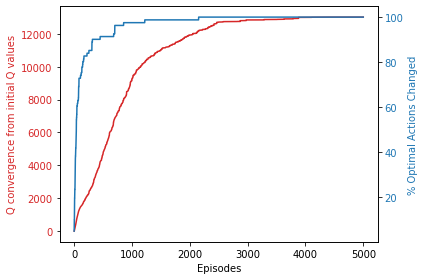

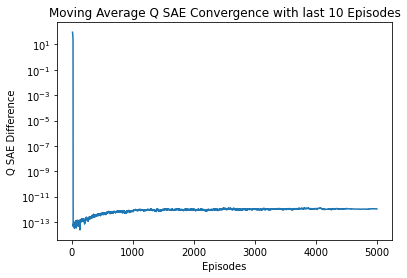

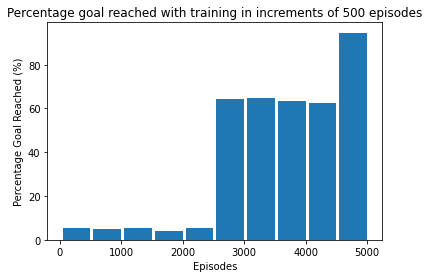

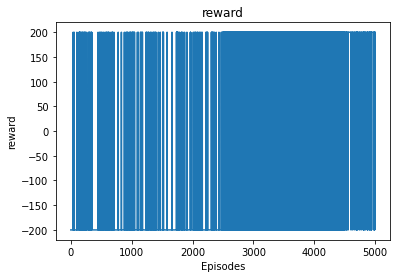

In [ ]:
env.visualise()

And that's it! That is how easy it is to control the entire training and visualise the output. Now we can try more variations on the 4 by 4 grid. We can implement SARSA. But first we must reset the training using the reset_training method.

🤖  ◦   ◦   ◦   ◦   

◦   ◦   ☠  ◦   ◦   

◦   ☠  ◦   ◦   ◦   

◦   ◦   ◎   ☠  ☠  

◦   ◦   ◦   ◦   ◦   



1 for go, 0 for no go: 1
Episode:  5000 / 5000
Training Complete


Final Policy Obtained:
↓   ←   ←   →   →   

↓   ↑   ☠  →   ↑   

↓   ☠  ↓   ←   ↑   

→   →   ◎   ☠  ☠  

→   →   ↑   ←   →   





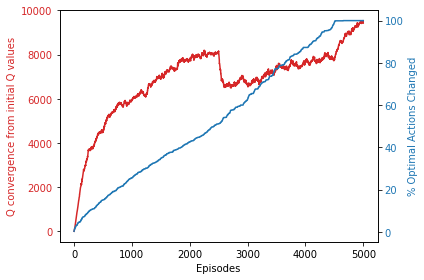

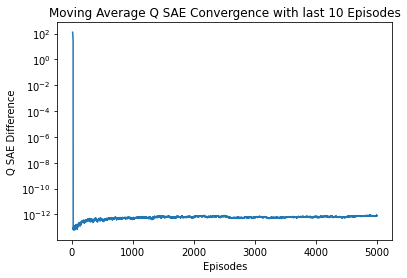

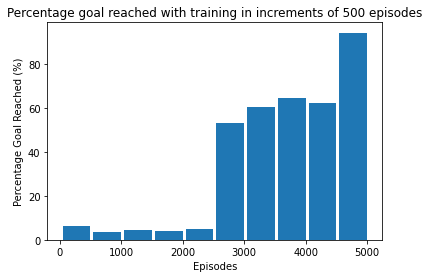

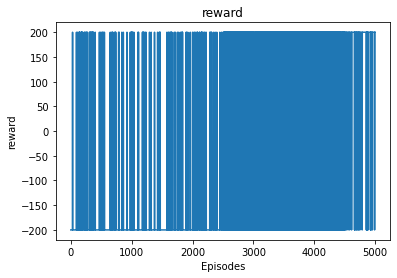

In [ ]:
env.reset_training()
env.train(episodes = 5000, discount = 0.9, algorithm = "sarsa", learning_rate = 0.1, verbose = 1, epsilon_schedule = epsilon_schedule)
env.visualise()

Amazing! We got the optimal policy again. Now we can finally try first-visit montecarlo withour exploring starts (ES). Note that a discount factor of 1.0 appears to give a better policy. Also note that with my source code, I also support every-visit (ev) monte carlo, and "with ES" assumption for montecarlo. Hence I can run 4 different types of monte-carlo algorithms.

🤖  ◦   ◦   ◦   ◦   

◦   ◦   ☠  ◦   ◦   

◦   ☠  ◦   ◦   ◦   

◦   ◦   ◎   ☠  ☠  

◦   ◦   ◦   ◦   ◦   



1 for go, 0 for no go: 1
Episode:  5000 / 5000
Training Complete


Final Policy Obtained:
↓   ←   ↑   ↓   ↓   

↓   ←   ☠  ↓   ↓   

↓   ☠  ↓   ←   ←   

→   →   ◎   ☠  ☠  

→   →   ↑   ←   ←   





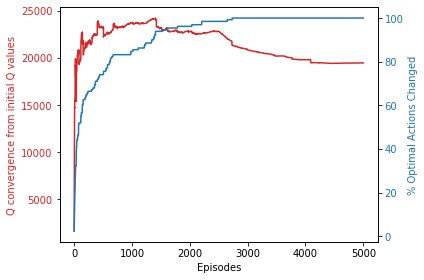

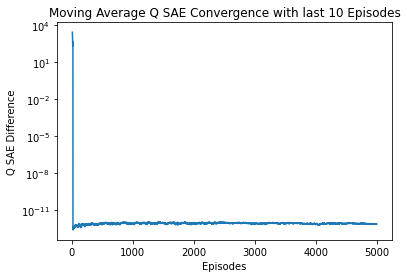

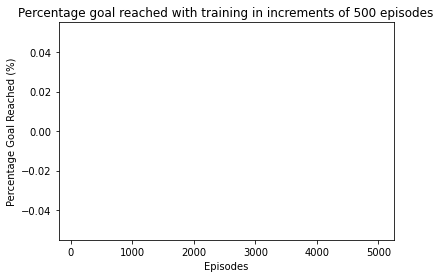

In [ ]:
env.reset_training()
env.train(episodes = 5000, discount = 1.0, algorithm = "fv-montecarlo_withoutES", learning_rate = 0.1, verbose = 1, epsilon_schedule = epsilon_schedule)
env.visualise()

Fantastic! an optimal policy has been reached again. Now let us try Q learning on a 10 by 10 grid. This requires the use of the "custom" option for creating the FrozenLake object. We set N = 10 and M = 10 (N by M grid) with the fraction_holes at 0.25 (to match Task 1) and the robot at the top left and the ffrisbee at the bottom left. I will train for 100,000 episodes! The larger grid takes a lot more training. Note: A random seed of 42 is applied to match the 10 by 10 grid shown in the report. 

Keep in mind that this may take a few minutes to finish training.

🤖  ◦   ◦   ◦   ☠  ☠  ☠  ☠  ◦   ◦   

◦   ◦   ◦   ☠  ◦   ☠  ☠  ◦   ☠  ◦   

☠  ◦   ◦   ◦   ◦   ◦   ◦   ◦   ◦   ◦   

◦   ☠  ◦   ◦   ☠  ◦   ◦   ☠  ☠  ☠  

◦   ◦   ☠  ◦   ◦   ◦   ◦   ◦   ◦   ◦   

◦   ◦   ◦   ◦   ◦   ◦   ◦   ◦   ◦   ◦   

◦   ◦   ◦   ☠  ◦   ◦   ◦   ◦   ◦   ◦   

◦   ◦   ◦   ◦   ◦   ◦   ◦   ☠  ◦   ◦   

☠  ◦   ☠  ◦   ◦   ◦   ☠  ◦   ◦   ◦   

☠  ☠  ◦   ◦   ◦   ☠  ◦   ☠  ☠  ◎   



1 for go, 0 for no go: 1
Episode:  100000 / 100000
Training Complete


Final Policy Obtained:
→   →   ↓   ←   ☠  ☠  ☠  ☠  ↑   ~   

→   →   ↓   ☠  ↓   ☠  ☠  ↓   ☠  ↑   

☠  →   →   →   →   →   ↓   ←   ←   ←   

↓   ☠  →   ↓   ☠  →   ↓   ☠  ☠  ☠  

~   ↓   ☠  →   →   →   →   →   →   ↓   

→   →   →   →   →   →   →   →   →   ↓   

→   →   ↑   ☠  →   →   →   →   →   ↓   

↑   ↑   ↑   →   →   ↑   ↑   ☠  →   ↓   

☠  ↑   ☠  ↑   →   ↑   ☠  →   →   ↓   

☠  ☠  ↑   ~   ↑   ☠  ~   ☠  ☠  ◎   





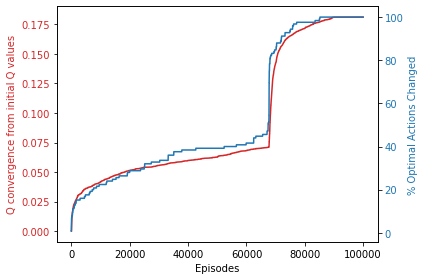

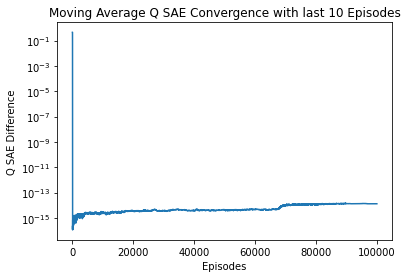

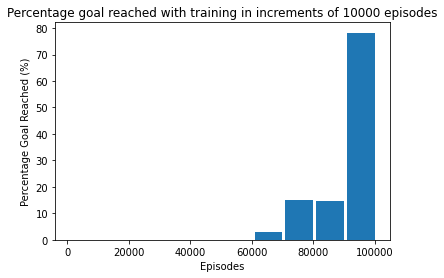

In [ ]:
random.seed(42)
env = FrozenLake(gridlake_type = 'custom', N = 10, M = 10, fraction_holes = 0.25, robot_coordinate = [0,0], frisbee_coordinate = [9,9])
env.train(episodes = 100000, discount = 0.9, algorithm = "qlearning", learning_rate = 0.1, verbose = 1, epsilon_schedule = epsilon_schedule)
env.visualise()

Great! We got a very near optimal policy. The optimal policy would take up to 1 million episodes of training! (Refer to my report). Finally, The cool thing about my code implementation is that I can specify what N by M grid size I want, with a fraction_holes of my choice and a robot starting coordinate and frisbee coordinate of my choice. The following cell shows such a custom implementation

◦   ☠  ◦   ☠  ☠  ☠  

◦   ☠  🤖  ◦   ☠  ☠  

◦   ◦   ◦   ◦   ◦   ◦   

◦   ◦   ☠  ◦   ◦   ◦   

◦   ☠  ◦   ◦   ◎   ◦   

☠  ☠  ◦   ◦   ☠  ◦   



1 for go, 0 for no go: 1
Episode:  10000 / 10000
Training Complete


Final Policy Obtained:
↓   ☠  ↓   ☠  ☠  ☠  

↓   ☠  →   ↓   ☠  ☠  

→   →   →   →   ↓   ←   

↑   ↑   ☠  →   ↓   ←   

↑   ☠  →   →   ◎   ←   

☠  ☠  ↑   ↑   ☠  ↑   





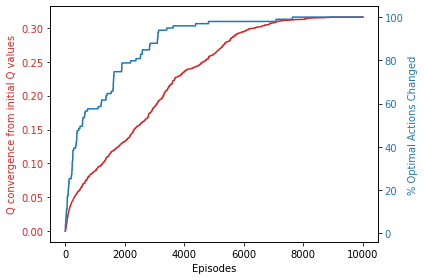

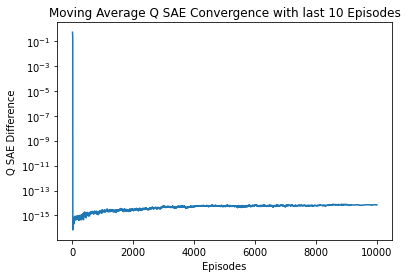

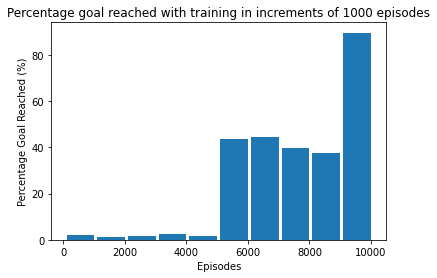

In [ ]:
random.seed(42)
env = FrozenLake(gridlake_type = 'custom', N = 6, M = 6, fraction_holes = 0.35, robot_coordinate = [1,2], frisbee_coordinate = [4,4])
env.train(episodes = 10000, discount = 0.9, algorithm = "qlearning", learning_rate = 0.1, verbose = 1, epsilon_schedule = epsilon_schedule)
env.visualise()

Once again, we achieved an optimal policy. That is all. I enjoyed coding this and I do sincerely hope my efforts to add more features, make the code clean and many comments to explain the code will be recognised. When I have free time in the future, I will add dynamic programming algorithms to solve this frozen lake problem. Thank you!